In [1]:
# %pip install showast@git+https://github.com/tzaffi/show_ast@source-offsets --upgrade
from showast import Settings, Renderers, show_text, show_ast, show_source, showast

Settings.update(dict(
    # Styling options:
    scale=1,
    font='courier',
    shape='none',
    terminal_color='#008040',
    nonterminal_color='#004080',

    # AST display options:
    omit_module=True,
    omit_docstrings=True,

    # By default omit_location_info is True
    omit_location_info=False,
    locations_format="L{begin[0]}:{begin[1]}-L{end[0]}:{end[1]}",

    # Rendering engine is expected to expose "render" function
    renderer=Renderers.graphviz,
))

In [44]:
# from dis import show_code
# from dataclasses import dataclass
# import dis

import pyteal as pt

import ast
# from collections import OrderedDict
import json
import itertools
import inspect
import graphviz
from pprint import pprint
from tabulate import tabulate
from typing import Any, Iterable

In [3]:
hello = pt.Seq(pt.Log(pt.Concat(pt.Bytes("hello"),
    pt.Bytes("world"))), 
    pt.Int(1),
)

In [4]:
goodbye = pt.Return(pt.Int(42))

## EDGE CASE PROBLEM - Will not map operator in PyTeal code to TEAL when operator on its own line

This seems to be a systemic issue with `inspect.stack()` and frames. For example, consider the following cell and try to debug it.

You _CANNOT EVEN SET BREAKPOINTS_ at the `+` operators.

In [5]:
x = 42
y = (
    pt.Int(1) 
    + 
    pt.Int(2) 
    + 
    pt.Int(3) 
    + 
    pt.Int(4) 
    + 
    pt.Int(5)
)

In [6]:
from an_expression import goodnum as goodnum
from pyteal.types import TealType

x = pt.ScratchVar(TealType.uint64)

pure = pt.Seq(
    pt.Pop(hello), 
    pt.Pop(goodnum),
    x.store(pt.Int(1000)),
    pt.Pop(pt.Int(1337) - pt.Int(42)),
    goodbye,
)

In [7]:
simple_add = pt.Int(1) + pt.Int(2) + pt.Int(3) + pt.Int(4) + pt.Int(5)

In [8]:
line_sep_add = (pt.Int(1) 
    +
    pt.Int(2)
     +
    pt.Int(3)
     +
    pt.Int(4)
     +
    pt.Int(5)
)

In [9]:
line_sep_pt_add = pt.Add(
    pt.Add(
        pt.Add(
            pt.Add(
                pt.Int(1),
                pt.Int(2),
            ),
            pt.Int(3),
        ),
        pt.Int(4),
    ),
    pt.Int(5),
)

In [10]:
from some_subroutines import double_exp, cat

some_subroutines = pt.Seq(
    pt.Log(cat(pt.Bytes("Mapping "), pt.Bytes("PyTeal"))),
    pt.Log(pt.Bytes("this compiles but it'll blow up when executed")),
    double_exp(),
)

In [11]:
program = {
    "pure": pure,
    "simple add": simple_add,
    "line sep add": line_sep_add,
    "line sep pt.Add": line_sep_pt_add,
    "some subroutines":  some_subroutines,
}

In [12]:
c = itertools.count()

def next_idx():
    return 6 + next(c)

source = {
    "pure": _ih[next_idx()],
    "simple add": _ih[next_idx()],
    "line sep add": _ih[next_idx()],
    "line sep pt.Add": _ih[next_idx()],
    "some subroutines":  _ih[next_idx()],
}

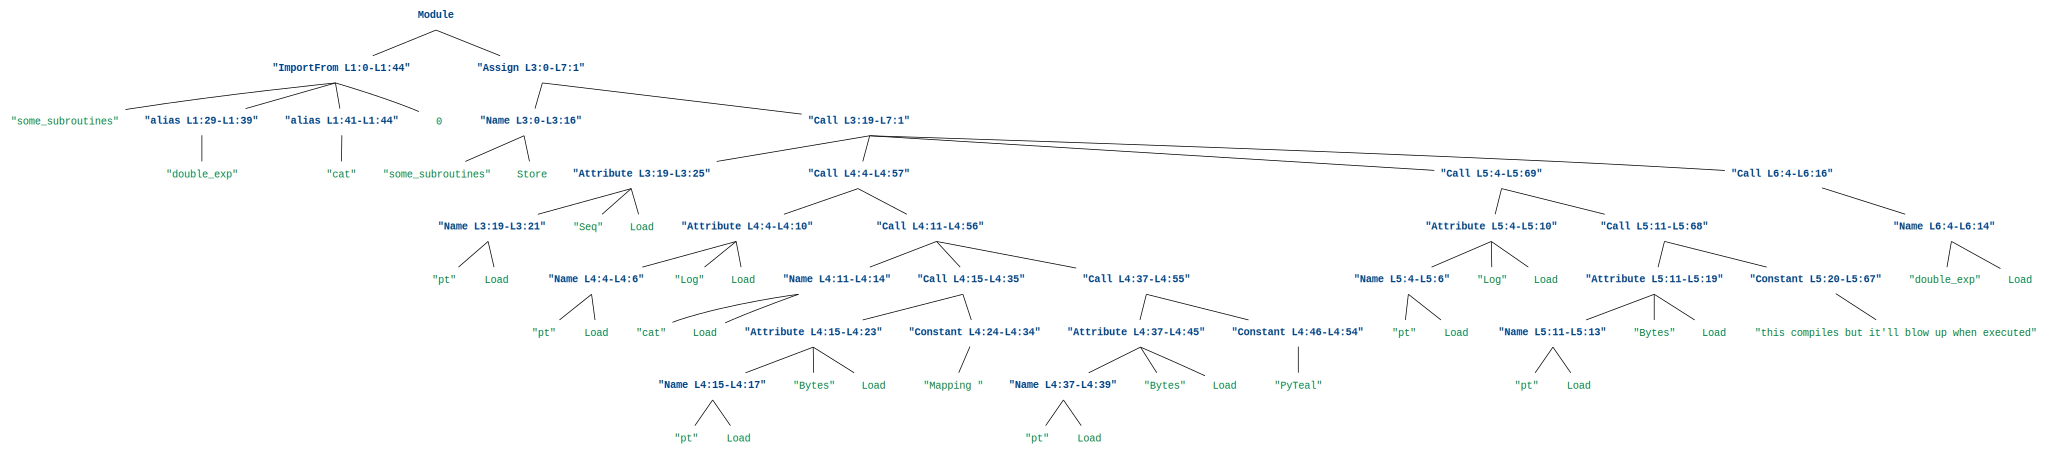

[TealPragma(7),
 TealOp(byte, '"Mapping "'),
 TealOp(byte, '"PyTeal"'),
 TealOp(callsub, 'cat_2'),
 TealOp(log),
 TealOp(byte, '"this compiles but it\'ll blow up when executed"'),
 TealOp(log),
 TealOp(callsub, 'doubleexp_1'),
 TealOp(return),
 TealLabel(None, 'exp_0', 'exp'),
 TealOp(int, 2),
 TealOp(int, 10),
 TealOp(exp),
 TealOp(retsub),
 TealLabel(None, 'doubleexp_1', 'double_exp'),
 TealOp(callsub, 'exp_0'),
 TealOp(callsub, 'exp_0'),
 TealOp(exp),
 TealOp(retsub),
 TealLabel(None, 'cat_2', 'cat'),
 TealOp(store, 1),
 TealOp(store, 0),
 TealOp(load, 0),
 TealOp(load, 1),
 TealOp(concat),
 TealOp(retsub)]

In [13]:
teals, lines, components = pt.compileTeal(program["some subroutines"], pt.Mode.Application, version=7)
show_text(source["some subroutines"])
components

In [14]:
print(f"""{teals=}
{lines=}
{components=}""")

teals='#pragma version 7\nbyte "Mapping "\nbyte "PyTeal"\ncallsub cat_2\nlog\nbyte "this compiles but it\'ll blow up when executed"\nlog\ncallsub doubleexp_1\nreturn\n\n// exp\nexp_0:\nint 2\nint 10\nexp\nretsub\n\n// double_exp\ndoubleexp_1:\ncallsub exp_0\ncallsub exp_0\nexp\nretsub\n\n// cat\ncat_2:\nstore 1\nstore 0\nload 0\nload 1\nconcat\nretsub'
lines=['#pragma version 7', 'byte "Mapping "', 'byte "PyTeal"', 'callsub cat_2', 'log', 'byte "this compiles but it\'ll blow up when executed"', 'log', 'callsub doubleexp_1', 'return', '\n// exp\nexp_0:', 'int 2', 'int 10', 'exp', 'retsub', '\n// double_exp\ndoubleexp_1:', 'callsub exp_0', 'callsub exp_0', 'exp', 'retsub', '\n// cat\ncat_2:', 'store 1', 'store 0', 'load 0', 'load 1', 'concat', 'retsub']
components=[TealPragma(7), TealOp(byte, '"Mapping "'), TealOp(byte, '"PyTeal"'), TealOp(callsub, 'cat_2'), TealOp(log), TealOp(byte, '"this compiles but it\'ll blow up when executed"'), TealOp(log), TealOp(callsub, 'doubleexp_1'), TealOp(

In [70]:
from dataclasses import dataclass
from typing import OrderedDict

from pyteal.ir.tealcomponent import TealComponent

class PyTealFrame:
    def __init__(self, frame: inspect.FrameInfo | None):
        self.frame = frame
        self.source = None
        self.ast = None
        self._raw_code = None

    commentary = {
        "# T2PT0": "PyTeal generated pragma",
        "# T2PT1": "PyTeal generated label",
        "# T2PT2": "PyTeal generated return for TealType.none",
        "# T2PT3": "PyTeal generated return for non-null TealType",
        "# T2PT4": "PyTeal generated subroutine parameter handler instruction",
    }

    def location(self) -> str:
        return f"{self.file()}:{self.lineno()}" if self.frame else ""

    def file(self) -> str:
        return self.frame.filename if self.frame else ""

    def lineno(self) -> int | None:
        return self.frame.lineno if self.frame else None

    def raw_code(self) -> str:
        if self._raw_code is None:
            self._raw_code = ("".join(self.frame.code_context)).strip() if self.frame and self.frame.code_context else ""

        return self._raw_code

    def compiler_generated(self) -> bool | None:
        """None indicates "unknown"."""
        if not self.raw_code():
            return None # we don't know / NA

        return "# T2PT" in self.raw_code()


    def code(self) -> str:
        raw = self.raw_code()
        if not self.compiler_generated():
            return raw 

        for k, v in self.commentary.items():
            if k in raw:
                return f"{v}: {raw}"
                
        return f"Unhandled # T2PT commentary: {raw}"
        
    
    def __str__(self, verbose: bool = True) -> str:
        if not self.frame:
            return "None"

        spaces = "\n\t\t\t"
        short = f"<{self.code()}>{spaces}@{self.location()}"
        if not verbose:
            return short

        return f"""{short}
{self.source=}
{self.ast=}
{self.frame.index=}
{self.frame.function=}
{self.frame.frame=}"""

    def __repr__(self) -> str:
        return self.__str__(verbose=False)

    @classmethod
    def convert(cls, fs: inspect.FrameInfo | list):
        if isinstance(fs, inspect.FrameInfo):
            return cls(fs)
        return [cls.convert(f) for f in fs]

@dataclass
class SourceMapItem:
    line: int
    teal: str
    component: TealComponent
    frame: PyTealFrame
    extras: dict[str, Any]

    @classmethod
    def fields(cls) -> list[str]:
        return ["TL", "Teal", "PyTeal", "PT path", "PTL", "PT component", "PT frame"]

    def asdict(self, **kwargs) -> OrderedDict:
        """kwargs serve as a rename mapping when present
        """
        assert not kwargs.keys() - set(self.fields())

        attrs = {
            "TL": self.line,
            "Teal": self.teal,
            "PyTeal": self.frame.code(),
            "PT path": self.frame.file(),
            "PTL": self.frame.lineno(),
            "PT component": self.component,
            "PT frame": self.frame,
        }
        return OrderedDict(((kwargs[k], attrs[k]) for k in kwargs))

def get_source_map(
    teal_lines: list[str],
    teal_components: list[pt.TealComponent],
    add_extras: bool = False,
) -> dict:
    N = len(teal_lines)
    assert N == len(teal_components), f"expected same number of teal lines {N} and components {len(teal_components)}"

    best_frames = []
    before, after = [], []
    for tc in teal_components:
        f, a, b = best_frame_and_more(tc)
        best_frames.append(f)
        before.append(b)
        after.append(a)

    def source_map_item(i, tc):
        extras = None
        if add_extras:
            extras = {
                "after_frames": after[i],
                "before_frames": before[i],
            }
        return SourceMapItem(i+1, teal_lines[i], tc, best_frames[i], extras)

    return {i+1: source_map_item(i, tc) for i, tc in enumerate(teal_components)}


def best_frame_and_more(t: pt.TealComponent) -> tuple[inspect.FrameInfo | None, list[inspect.FrameInfo], list[inspect.FrameInfo]]:
    match t:
        case pt.TealOp():
            assert t.expr is not None, f"provided TealOp {t} missing Expr"
            frames_reversed = t.expr.frames
            path_match = "pyteal/ast"
        case pt.TealLabel() | pt.TealPragma():
            frames_reversed = t.frames
            path_match = "pyteal/ir"
        case _:
            raise Exception(f"expected TealComponent but got {type(t)}")

    pyteals = [
        path_match,
        "tests/abi_roundtrip.py",
        "tests/blackbox.py",
        "tests/compilea_asserts.py",
        "tests/mock_version.py",
    ]
    
    pyteal_idx = [any(w in f.filename for w in pyteals) for f in frames_reversed]

    in_pt, first_pt_entrancy = False, None
    for i, is_pyteal in enumerate(pyteal_idx):
        if is_pyteal and not in_pt:
            in_pt = True
            continue
        if not is_pyteal and in_pt:
            first_pt_entrancy = i
            break

    if first_pt_entrancy is None:
        return None, [], []
    return tuple(PyTealFrame.convert([
        frames_reversed[first_pt_entrancy], 
        [frames_reversed[i] for i in range(first_pt_entrancy-1, -1, -1)], 
        [frames_reversed[i] for i in range(first_pt_entrancy+1, len(frames_reversed))],
    ])) # type: ignore

def tabulate_source_map(
    m: dict[int, SourceMapItem],
    columns=["TL", "Teal", "PyTeal", "PT path", "PTL", "PT component"],
    tablefmt="fancy_grid"
) -> str:
    headers = {col: col for col in columns}
    rows = (item.asdict(**headers) for item in m.values())
    return tabulate(rows, headers=headers, tablefmt=tablefmt)

In [71]:
m = get_source_map(lines, components, add_extras=True)
print(tabulate_source_map(m))

╒══════╤══════════════════════════════════════════════════════╤══════════════════════════════════════════════════════════════════════════════════════════════════════╤════════════════════════════════════════════════════════════════════════════════╤═══════╤══════════════════════════════════════════════════════════════════╕
│   TL │ Teal                                                 │ PyTeal                                                                                               │ PT path                                                                        │   PTL │ PT component                                                     │
╞══════╪══════════════════════════════════════════════════════╪══════════════════════════════════════════════════════════════════════════════════════════════════════╪════════════════════════════════════════════════════════════════════════════════╪═══════╪══════════════════════════════════════════════════════════════════╡
│    1 │ #pragma version 7     

In [75]:
program.keys()

dict_keys(['pure', 'simple add', 'line sep add', 'line sep pt.Add', 'some subroutines'])

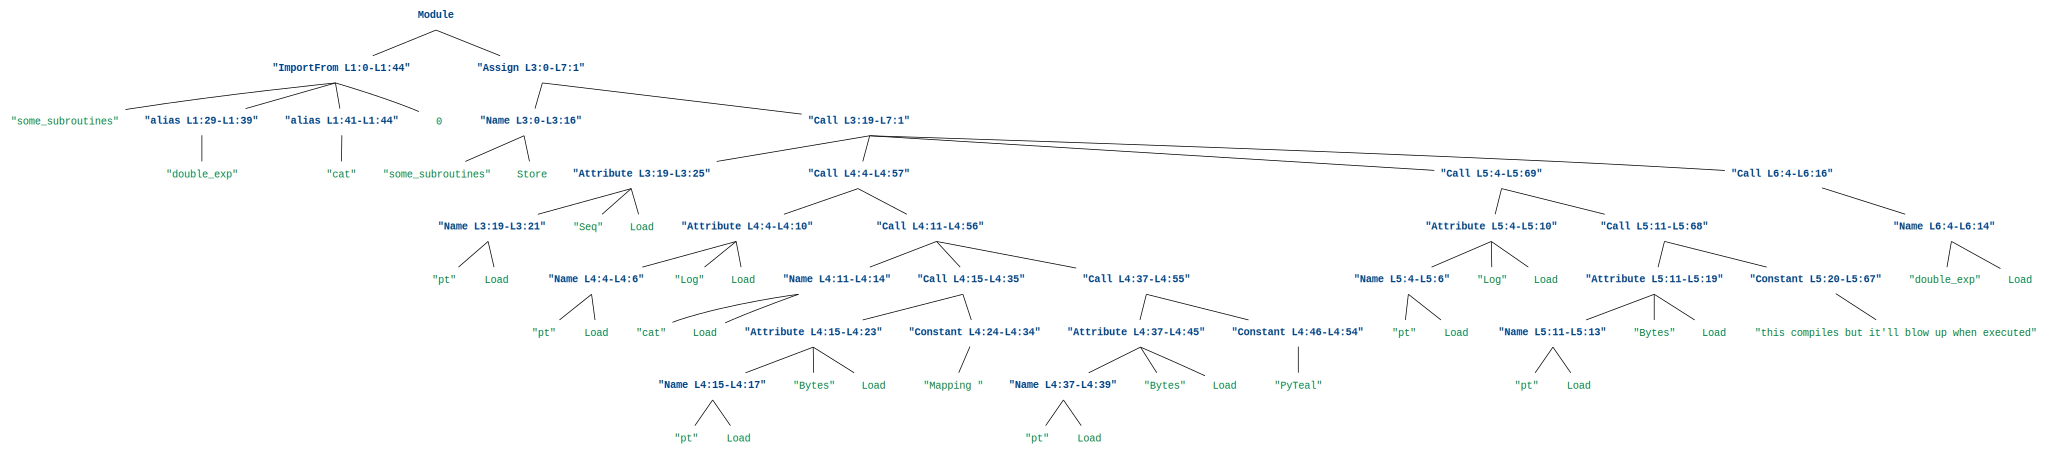

╒══════╤═══════════════════╤════════════════════════════════════════════════════════════════════════════════╤════════════════════════════════════════════════════════════════════════════════╤═══════╤════════════════╕
│   TL │ Teal              │ PyTeal                                                                         │ PT path                                                                        │   PTL │ PT component   │
╞══════╪═══════════════════╪════════════════════════════════════════════════════════════════════════════════╪════════════════════════════════════════════════════════════════════════════════╪═══════╪════════════════╡
│    1 │ #pragma version 7 │ PyTeal generated pragma: teal = [TealPragma(version)] + teal  # T2PT0          │ /Users/zeph/github/tzaffi/pyteal/pyteal/compiler/compiler.py                   │   329 │ TealPragma(7)  │
├──────┼───────────────────┼────────────────────────────────────────────────────────────────────────────────┼───────────────────────────

In [77]:
def run_example(program_key="some subroutines"):
    _, lines, components = pt.compileTeal(program[program_key], pt.Mode.Application, version=7)
    m = get_source_map(lines, components, add_extras=True)
    show_text(source["some subroutines"])
    print(tabulate_source_map(m))

run_example("simple add")

# Wrongs!!!
```
12: (TealOp(callsub, 'exp_0'),
      return self.subroutine(*args, **kwargs),
      [return self.subroutine.invoke(list(args)),
       return SubroutineCall(,
       args[0].frames = inspect.stack()],
      [return exp() ** exp()  # type: ignore,
       subroutine_body = subroutine.implementation(*loaded_args, **abi_output_kwargs),
```

In [22]:
pprint(m, indent=1)

{1: SourceMapItem(line=1,
                  teal='#pragma version 7',
                  component=TealPragma(7),
                  frame=<PyTeal generated pragma: teal = [TealPragma(version)] + teal  # T2PT0>
			@/Users/zeph/github/tzaffi/pyteal/pyteal/compiler/compiler.py:329,
                  extras={'after_frames': [<self.frames = inspect.stack()>
			@/Users/zeph/github/tzaffi/pyteal/pyteal/ir/tealpragma.py:9],
                          'before_frames': [<teals, lines, components = pt.compileTeal(program["some subroutines"], pt.Mode.Application, version=7)>
			@/var/folders/xf/ks83gjdd16dctb70r8p79w8h0000gp/T/ipykernel_32905/4213459991.py:1,
                                            <exec(code_obj, self.user_global_ns, self.user_ns)>
			@/Users/zeph/github/tzaffi/pyteal/py310ptt/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3398,
                                            <if await self.run_code(code, result, async_=asy):>
			@/Users/zeph/github/tzaffi/pyteal/py3

In [18]:
pprint({k: v[:2] for k, v in m.items()})

TypeError: 'SourceMapItem' object is not subscriptable

In [ ]:
# class ASTCache:
#     frozen: bool = False

#     _sources: dict[string, string] = {}
#     _asts: dice[string, ]

def add_asts_to_frames(frames: Iterable[PyTealFrame]):
    """And do it without compiling more than once per file"""
    def get_jupyter_index(code) -> int | None:
        indices = [i for i, cell_code in enumerate(_ih) if code in cell_code]
        return indices[0] if indices else None


    locations = [f.location() for f in frames]
    files = [f.file() for f in frames]
    codes = [f.code() for f in frames]
    jupyter_idx = [get_jupyter_index(c) for c in codes]
    # file2source = {f. for i, idx in enumerate(jupyter_idx) }
    # sources = [_ih[idx] if idx is not None else open(files[i]).read() for i, idx in enumerate(jupyter_idx)]

    file2source = {}
    file2ast = {}
    for i, f in enumerate(files):
        if f in file2source:
            continue

        idx = jupyter_idx[i]
        source = _ih[idx] if idx is not None else open(f).read()

        file2source[f] = source
        file2ast[f] = ast.parse(source)

    
    for i, f in enumerate(frames):
        idx = jupyter_idx[i]
        file = f.file()
        f.source = file2source[file]
        f.ast = file2ast[file]
    
    
    return file2source, file2ast

In [ ]:
frames = [pt_frame for (_, (_, pt_frame)) in m.items()]

add_asts_to_frames(frames)

In [ ]:
import ast
from pprint import pprint

class CallVisitor(ast.NodeVisitor):
    def print(self, node):
        nl = "_" * 10 + "\n"
        print(f"{nl}Node{type(node)} [{node.lineno}:{node.col_offset}-->{node.end_lineno}:{node.end_col_offset}]")
        for f in node._fields:
            print(f"{f}={getattr(node, f)}")
        

    def visit_Call(self, node):
        self.print(node)
        ast.NodeVisitor.generic_visit(self, node)

    def visit_Name(self,node):
        self.print(node)
        # print('Node type: Name\nFields: ', node._fields)
        ast.NodeVisitor.generic_visit(self, node)

    def visit_Constant(self,node):
        self.print(node)
        # print('Node type: Constant\nFields: ', node._fields)
        ast.NodeVisitor.generic_visit(self, node)

    def visit_keyword(self,node):
        self.print(node)
        # print('Node type: keyword\nFields: ', node._fields)
        ast.NodeVisitor.generic_visit(self, node)



visitor = CallVisitor()
tree = ast.parse("myfunc(a, 100, found=True)", mode='eval')
pprint(ast.dump(tree))
visitor.visit(tree)

In [ ]:
visitor.visit(frames[1].ast)

In [ ]:
print(ast.dump(frames[1].ast, include_attributes=True, indent="  "))

In [ ]:
t = (1,2,3,4)

t.count(3)

In [ ]:
idx = 5
m[idx][1].lineno, m[idx][1].code_context, m[idx][1].frame, m[idx][1]._asdict()

In [ ]:
idx = 6
m[idx][1].lineno, m[idx][1].code_context, m[idx][1].frame, m[idx][1]._asdict()

In [ ]:
idx = 7
m[idx][1].lineno, m[idx][1].code_context, m[idx][1].frame, m[idx][1]._asdict()

In [ ]:
len(m)

In [ ]:
m.keys()